In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    average_precision_score
)
from sklearn.model_selection import learning_curve

In [22]:
print("--- Загрузка обработанных данных ---")
try:
    X_train = pd.read_csv('../data/processed/X_train_processed.csv')
    X_test = pd.read_csv('../data/processed/X_test_processed.csv')

    y_train = pd.read_csv('../data/processed/y_train.csv').squeeze('columns')
    y_test = pd.read_csv('../data/processed/y_test.csv').squeeze('columns')

    if not isinstance(y_train, pd.Series):
        y_train_cols = pd.read_csv('../data/processed/y_train.csv').columns
        if len(y_train_cols) > 0:
             print(f"Предупреждение: y_train прочитался как DataFrame. Используется колонка '{y_train_cols[0]}'")
             y_train = pd.read_csv('../data/processed/y_train.csv')[y_train_cols[0]]
        else:
             raise ValueError("Файл y_train.csv пуст или не содержит данных.")
    if not isinstance(y_test, pd.Series):
        y_test_cols = pd.read_csv('../data/processed/y_test.csv').columns
        if len(y_test_cols) > 0:
             print(f"Предупреждение: y_test прочитался как DataFrame. Используется колонка '{y_test_cols[0]}'")
             y_test = pd.read_csv('../data/processed/y_test.csv')[y_test_cols[0]]
        else:
             raise ValueError("Файл y_test.csv пуст или не содержит данных.")


    print("Данные успешно загружены.")
    print(f"Размер X_train: {X_train.shape}")
    print(f"Размер X_test: {X_test.shape}")
    print(f"Тип y_train: {type(y_train)}")
    print(f"Тип y_test: {type(y_test)}")

    print(f"Доля оттока в y_test: {y_test.mean():.3f}")

except FileNotFoundError as e:
    print(f"Ошибка: Не найден файл. Проверьте пути. {e}")
except Exception as e:
    print(f"Произошла ошибка при загрузке или обработке данных: {e}")

--- Загрузка обработанных данных ---
Данные успешно загружены.
Размер X_train: (8000, 14)
Размер X_test: (2000, 14)
Тип y_train: <class 'pandas.core.series.Series'>
Тип y_test: <class 'pandas.core.series.Series'>
Доля оттока в y_test: 0.203


In [23]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Оценивает модель и выводит основные метрики."""
    print(f"\n--- Оценка модели: {model_name} ---")
    try:
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"PR AUC (Average Precision): {pr_auc:.4f}")
        else:
            y_pred_proba = None
            roc_auc = None
            pr_auc = None
            print("ROC AUC / PR AUC не могут быть посчитаны (нет predict_proba).")

        y_pred = model.predict(X_test)

        f1 = f1_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        precision = precision_score(y_test, y_pred, pos_label=1)

        print(f"F1 Score (Class 1): {f1:.4f}")
        print(f"Recall (Class 1): {recall:.4f}")
        print(f"Precision (Class 1): {precision:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Лоялен (0)', 'Отток (1)']))

        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Лоялен (0)', 'Отток (1)'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

        return {'roc_auc': roc_auc, 'f1_score_1': f1, 'recall_1': recall, 'precision_1': precision, 'pr_auc': pr_auc}

    except Exception as e:
        print(f"Ошибка при оценке модели {model_name}: {e}")
        return None


--- Обучение Baseline: Dummy Classifier (Stratified) ---

--- Оценка модели: Dummy Classifier (Stratified) ---
ROC AUC: 0.4885
PR AUC (Average Precision): 0.2001
F1 Score (Class 1): 0.1873
Recall (Class 1): 0.1892
Precision (Class 1): 0.1855

Classification Report:
              precision    recall  f1-score   support

  Лоялен (0)       0.79      0.79      0.79      1593
   Отток (1)       0.19      0.19      0.19       407

    accuracy                           0.67      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.67      0.67      0.67      2000

Confusion Matrix:
[[1255  338]
 [ 330   77]]


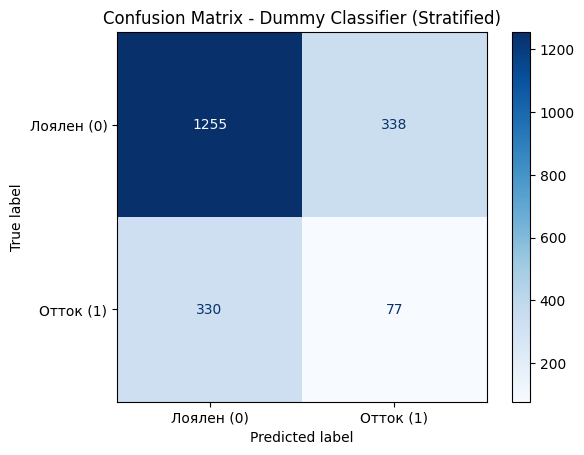

In [24]:
print("\n--- Обучение Baseline: Dummy Classifier (Stratified) ---")
dummy_stratified = DummyClassifier(strategy='stratified', random_state=42)
dummy_stratified.fit(X_train, y_train)
results_dummy_stratified = evaluate_model(dummy_stratified, X_test, y_test, "Dummy Classifier (Stratified)")


--- Обучение Baseline: Dummy Classifier (Most Frequent) ---

--- Оценка модели: Dummy Classifier (Most Frequent) ---
ROC AUC: 0.5000
PR AUC (Average Precision): 0.2035
F1 Score (Class 1): 0.0000
Recall (Class 1): 0.0000
Precision (Class 1): 0.0000

Classification Report:
              precision    recall  f1-score   support

  Лоялен (0)       0.80      1.00      0.89      1593
   Отток (1)       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000

Confusion Matrix:
[[1593    0]
 [ 407    0]]


c:\Users\pyramidheadshark\Repos\customer-churn-interactive-research\.pixi\envs\default\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pyramidheadshark\Repos\customer-churn-interactive-research\.pixi\envs\default\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pyramidheadshark\Repos\customer-churn-interactive-research\.pixi\envs\default\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

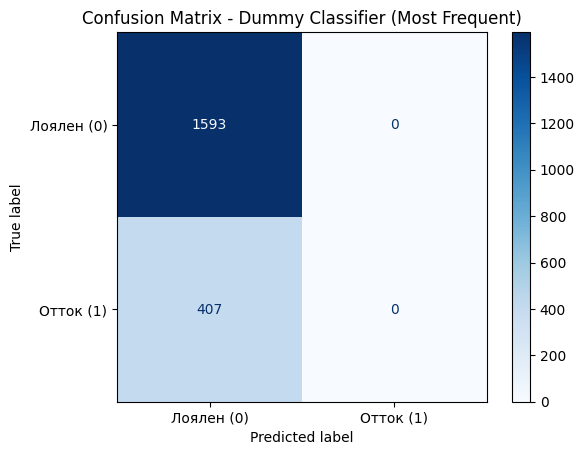

In [25]:
print("\n--- Обучение Baseline: Dummy Classifier (Most Frequent) ---")
dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_frequent.fit(X_train, y_train)
results_dummy_most_frequent = evaluate_model(dummy_most_frequent, X_test, y_test, "Dummy Classifier (Most Frequent)")


--- Обучение Baseline: Logistic Regression ---

--- Оценка модели: Logistic Regression (Balanced) ---
ROC AUC: 0.8443
PR AUC (Average Precision): 0.6310
F1 Score (Class 1): 0.5547
Recall (Class 1): 0.7543
Precision (Class 1): 0.4386

Classification Report:
              precision    recall  f1-score   support

  Лоялен (0)       0.92      0.75      0.83      1593
   Отток (1)       0.44      0.75      0.55       407

    accuracy                           0.75      2000
   macro avg       0.68      0.75      0.69      2000
weighted avg       0.82      0.75      0.77      2000

Confusion Matrix:
[[1200  393]
 [ 100  307]]


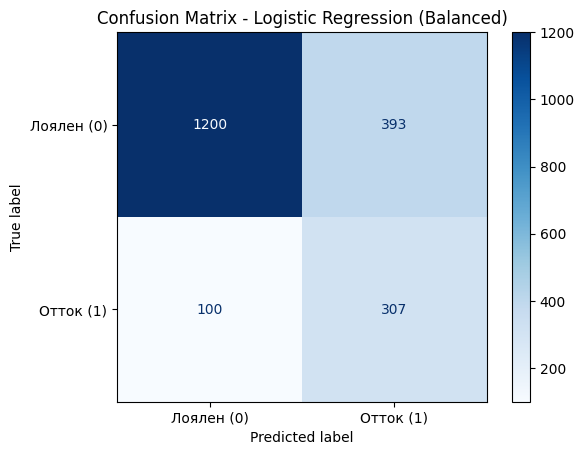

In [26]:
print("\n--- Обучение Baseline: Logistic Regression ---")
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
results_log_reg = evaluate_model(log_reg, X_test, y_test, "Logistic Regression (Balanced)")


--- Визуализация кривых для Logistic Regression ---


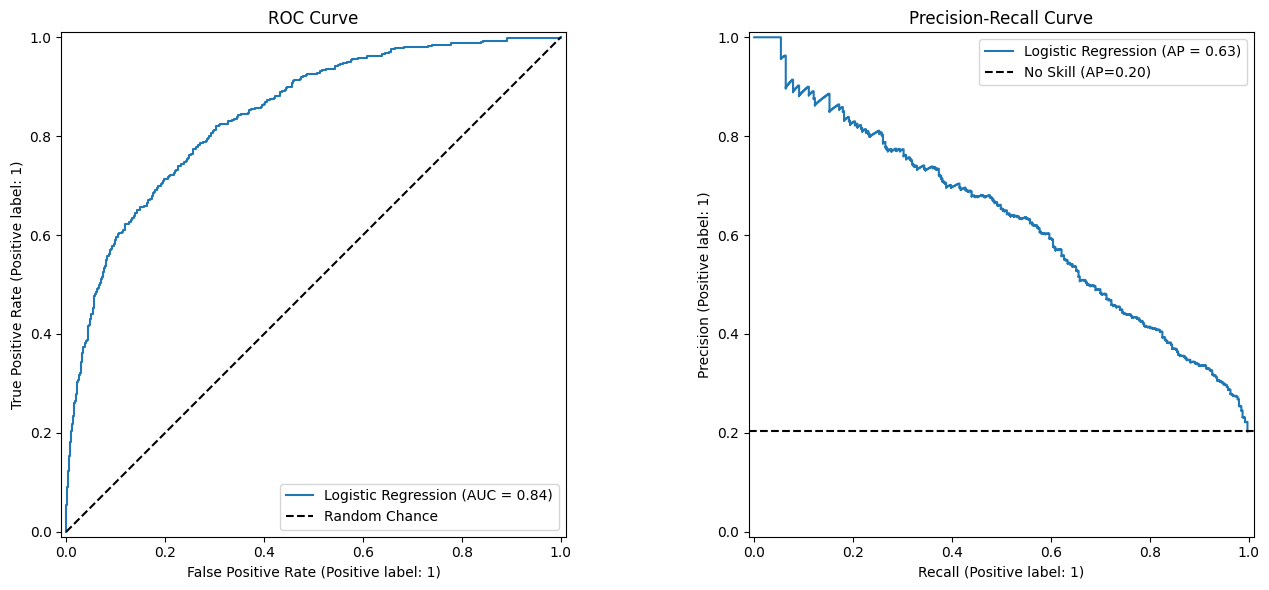

In [27]:
if hasattr(log_reg, "predict_proba"):
    print("\n--- Визуализация кривых для Logistic Regression ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curve
    RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax1, name='Logistic Regression')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Линия случайного угадывания
    ax1.set_title('ROC Curve')
    ax1.legend()

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test, ax=ax2, name='Logistic Regression')
    # Доля позитивного класса как baseline для PR кривой
    baseline_pr = y_test.mean()
    ax2.axhline(baseline_pr, color='k', linestyle='--', label=f'No Skill (AP={baseline_pr:.2f})')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [28]:
print("\n--- Сводка результатов Baseline (на тестовой выборке) ---")
results_summary = {
    "Dummy (Stratified)": results_dummy_stratified,
    "Dummy (Most Frequent)": results_dummy_most_frequent,
    "Logistic Regression (Balanced)": results_log_reg
}

summary_df = pd.DataFrame(results_summary).T # Транспонируем для удобства
print(summary_df[['roc_auc', 'pr_auc', 'f1_score_1', 'recall_1', 'precision_1']].round(4))


--- Сводка результатов Baseline (на тестовой выборке) ---
                                roc_auc  pr_auc  f1_score_1  recall_1  \
Dummy (Stratified)               0.4885  0.2001      0.1873    0.1892   
Dummy (Most Frequent)            0.5000  0.2035      0.0000    0.0000   
Logistic Regression (Balanced)   0.8443  0.6310      0.5547    0.7543   

                                precision_1  
Dummy (Stratified)                   0.1855  
Dummy (Most Frequent)                0.0000  
Logistic Regression (Balanced)       0.4386  
